In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv("/content/weatherAUS.csv")

In [5]:
data.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [10]:
data.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [11]:
col = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']
data = data[col]

In [12]:
data['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
data['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

In [13]:
data = data.dropna(how='any')

In [14]:
data.head(3)

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0.0,0.0
1,0.0,25.0,1010.6,0.0,0.0
2,0.0,30.0,1007.6,0.0,0.0


In [40]:
class NeuralNet():
           
    def __init__(self, layers=[4,5,1], learning_rate=0.001, iterations=100):
        self.params = {}
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = []
        self.sample_size = None
        self.layers = layers
        self.X = None
        self.y = None
                
    def init_weights(self):
        np.random.seed(1) 
        self.params["W1"] = np.random.randn(self.layers[0], self.layers[1]) 
        self.params['b1']  =np.random.randn(self.layers[1],)
        self.params['W2'] = np.random.randn(self.layers[1],self.layers[2]) 
        self.params['b2'] = np.random.randn(self.layers[2],)
    
    def relu(self,Z):
        return np.maximum(0,Z)

    def dRelu(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x

    def eta(self, x):
      ETA = 0.0000000001
      return np.maximum(x, ETA)

    def sigmoid(self,Z):
        return 1/(1+np.exp(-Z))

    def entropy_loss(self,y, yhat):
        nsample = len(y)
        yhat_inv = 1.0 - yhat
        y_inv = 1.0 - y
        yhat = self.eta(yhat) 
        yhat_inv = self.eta(yhat_inv) 
        loss = -1/nsample * (np.sum(np.multiply(np.log(yhat), y) + np.multiply((y_inv), np.log(yhat_inv))))
        return loss

    def forward_propagation(self):
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        yhat = self.sigmoid(Z2)
        loss = self.entropy_loss(self.y,yhat)

        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1

        return yhat,loss

    def back_propagation(self,yhat):
        y_inv = 1 - self.y
        yhat_inv = 1 - yhat

        dl_wrt_yhat = np.divide(y_inv, self.eta(yhat_inv)) - np.divide(self.y, self.eta(yhat))
        dl_wrt_sig = yhat * (yhat_inv)
        dl_wrt_z2 = dl_wrt_yhat * dl_wrt_sig

        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0, keepdims=True)

        dl_wrt_z1 = dl_wrt_A1 * self.dRelu(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0, keepdims=True)

        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.init_weights() 

        for i in range(self.iterations):
            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)
            self.loss.append(loss)

    def predict(self, X):
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = self.sigmoid(Z2)
        return np.round(pred) 

    def acc(self, y, yhat):
        acc = int(sum(y == yhat) / len(y) * 100)
        return acc


    def plot_loss(self):
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()  

In [45]:
X = data.drop(columns=['RainTomorrow'])

y_label = data['RainTomorrow'].values.reshape(X.shape[0], 1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size=0.2, random_state=2)

sc = StandardScaler()
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Xtest = sc.transform(Xtest)

print(f"Shape of train set is {Xtrain.shape}")
print(f"Shape of test set is {Xtest.shape}")
print(f"Shape of train label is {ytrain.shape}")
print(f"Shape of test labels is {ytest.shape}")

Shape of train set is (34634, 4)
Shape of test set is (8659, 4)
Shape of train label is (34634, 1)
Shape of test labels is (8659, 1)


In [46]:
nn = NeuralNet() 
nn.fit(Xtrain, ytrain)

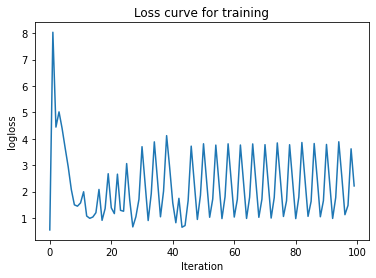

In [47]:
nn.plot_loss()

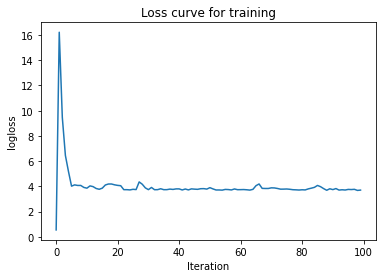

In [49]:
nn = NeuralNet(layers=[4,5,1], learning_rate=0.01, iterations=100) 
nn.fit(Xtrain, ytrain) 
nn.plot_loss()

In [50]:
train_pred = nn.predict(Xtrain)
test_pred = nn.predict(Xtest)

print("Train accuracy is {}".format(nn.acc(ytrain, train_pred)))
print("Test accuracy is {}".format(nn.acc(ytest, test_pred)))

Train accuracy is 83
Test accuracy is 84


In [53]:
sknet = MLPClassifier(hidden_layer_sizes=(8), learning_rate_init=0.001, max_iter=100)

In [52]:
sknet.fit(Xtrain, ytrain)
preds_train = sknet.predict(Xtrain)
preds_test = sknet.predict(Xtest)

print("Train accuracy of sklearn neural network: {}".format(round(accuracy_score(preds_train, ytrain),2)*100))
print("Test accuracy of sklearn neural network: {}".format(round(accuracy_score(preds_test, ytest),2)*100))

Train accuracy of sklearn neural network: 84.0
Test accuracy of sklearn neural network: 85.0
